In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import pathlib
import pandas as pd

# Инициализация GPU

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


# Parameters

In [3]:
dir_path = pathlib.Path.cwd()
dir_path = str(dir_path)
dir_path

'H:\\IntensiveGitHub\\Intensive'

In [4]:
DATASET_DIR = "All/"
NUM_CLASSES = 25

IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300

IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 75
NUM_WORKERS = 2
EPOCHS = 8

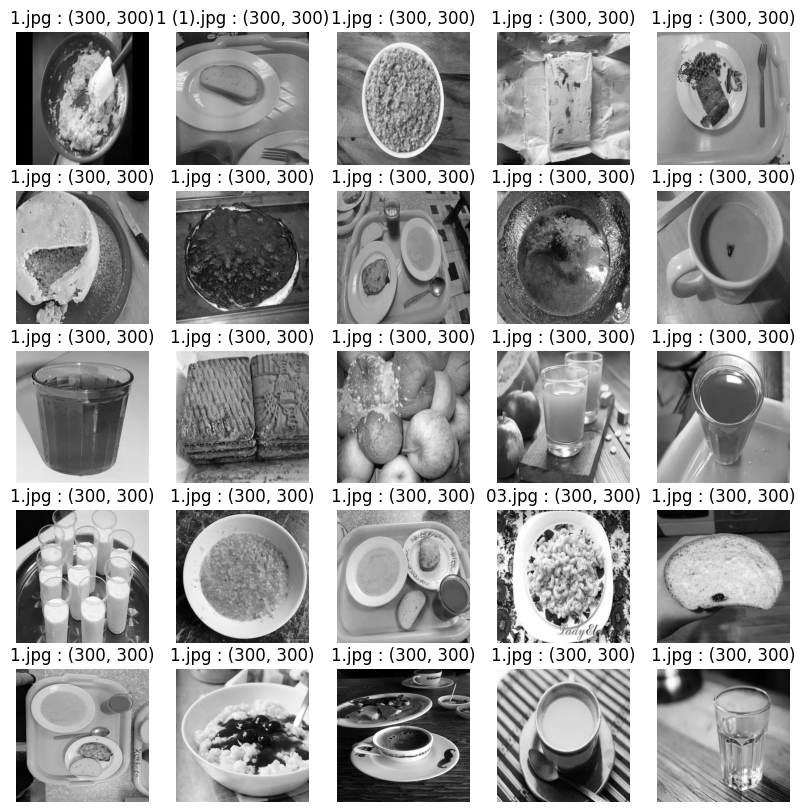

In [6]:
fig = plt.figure(figsize=(10, 10))
i = 0
for sub_dir in os.listdir(DATASET_DIR):
    i+=1
    img_file = os.listdir(os.path.join(DATASET_DIR,sub_dir))[0]
    img_path = os.path.join(DATASET_DIR, sub_dir, img_file)
    img = mpimg.imread(img_path)
    img_shape = np.array(img).shape
    a=fig.add_subplot(5, 5, i)
    a.axis('off')
    imgplot = plt.imshow(img, cmap='gray')
    a.set_title(img_file + ' : ' + str(img_shape))
plt.show()

In [10]:
classes = os.listdir(DATASET_DIR)
count_classes = len(classes)

In [16]:
from typing import List


class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, identity_downsample=None, stride: int = 1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x: torch.Tensor):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x


class ResNet(nn.Module):  # [3, 4, 6, 3]
    def __init__(self, block: Block, layers: List[int], image_channels: int, num_classes: int):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layers(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layers(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layers(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layers(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layers(self, block: Block, num_residual_blocks: int, out_channels: int, stride: int):
        identity_downsample = None
        layers = list()

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 4)
            )

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x


def resnet_50(img_channels: int = 3, num_classes: int = NUM_CLASSES):
    return ResNet(Block, [3, 4, 6, 3], img_channels, num_classes)


def test():
    net = resnet_50()
    x = torch.randn(1, 3, 128, 128)
    print(net(x).size())


test()

torch.Size([1, 25])


In [17]:
model = resnet_50()
model.to(device)

x = torch.randn(1, 3, 128, 128).to(device)
print(model(x).shape)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(model)

torch.Size([1, 25])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, mom

In [22]:
class TraffiSignDataset(Dataset):
    def __init__(self, dataset_dir: str, image_height: int, image_width: int, train: bool = False):
        super(TraffiSignDataset, self).__init__()
        self.dataset_dir = dataset_dir
        self.image_height = image_height
        self.image_width = image_width
        self.train = train

        dir_suffix = 'train' if self.train else 'test'
        label_name = 'TsignRecgTrain4170Annotation.txt' if self.train else 'TsignRecgTest1994Annotation.txt'

        self.image_dir = f'{self.dataset_dir}/images_{dir_suffix}/'
        self.label_path = f'{self.dataset_dir}/annotations_{dir_suffix}/{label_name}'

        self.image_names, self.x1y1x2y2s, self.labels = self._load_labels(self.label_path)

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
            ]
        )

    @staticmethod
    def _load_labels(path):
        with open(path, 'r') as f:
            labels = f.readlines()
        labels = [label.strip().split(';') for label in labels]
        image_names = [label[0] for label in labels]
        x1y1x2y2s = [(int(label[3]), int(label[4]), int(label[5]), int(label[6])) for label in labels]
        labels = [int(label[-2]) for label in labels]
        return image_names, x1y1x2y2s, labels

    def __getitem__(self, index):
        image = self.get_np_image(index)
        image = np.array(image / 255, dtype=np.float32)
        image = self.transform(image)
        label = self.labels[index]
        return image, label

    def get_np_image(self, index):
        image = cv2.imread(f'{self.image_dir}/{self.image_names[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x1, y1, x2, y2 = self.x1y1x2y2s[index]
        image = image[y1: y2, x1: x2, ...]
        image = cv2.resize(image, (self.image_width, self.image_height), interpolation=cv2.INTER_CUBIC)
        return image

    def __len__(self):
        return len(self.image_names)

In [23]:
def create_dataloader(dataset: Dataset, batch_size: int, num_workers: int, train: bool = False):
    return DataLoader(
        dataset=dataset, batch_size=batch_size,
        shuffle=train, num_workers=num_workers,
        pin_memory=True, drop_last=False)


def evaluate(model: nn.Module, dataloader: DataLoader, train: bool = False):
    model.eval()

    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    images = len(dataloader) * dataloader.batch_size
    prefix = "train" if train else "test"
    print(f'Accuracy of the network on the {images} {prefix} images: {(100 * correct / total):.2f} %')


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [24]:
train_dataset = TraffiSignDataset(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH, train=True)

test_dataset = TraffiSignDataset(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH)

train_dataloader = create_dataloader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, train=True)

test_dataloader = create_dataloader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

FileNotFoundError: [Errno 2] No such file or directory: 'All//annotations_train/TsignRecgTrain4170Annotation.txt'

In [ ]:
model.train()

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'epoch: {epoch:2d}, iteration: {i + 1:4d}, loss: {running_loss / 100:.3f}')
            running_loss = 0.0

model.eval();

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss


def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # return average loss for the epoch
    return avg_loss


# Now use the train and test functions to train and test the model

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs
epochs = 10
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

In [7]:
classes = os.listdir(DATASET_DIR)
classes.sort()
labels = pd.DataFrame({
    'Name': classes
})
labels = labels.reset_index()
labels

,index,Name
0,0,Baked_cheese_omelet
1,1,Bread_made_from_wheat_flour
2,2,Butter
3,3,Casserole
4,4,Cheese
5,5,Cheese_casserole
6,6,Cheese_sandwich
7,7,Cherry_Sauce
8,8,Coffee
9,9,Compote


In [8]:
labels.to_csv('labels.csv', encoding='utf8')

# Wrapping for dataset

In [ ]:
label_path = 'labels/labels.csv'
image_names, labels = _load_labels(label_path)

In [46]:
class All_Food_Drink(Dataset):
    def __init__(self, dataset_dir: str, image_height: int, image_width: int, train: bool = False):
        super(All_Food_Drink, self).__init__()
        self.dataset_dir = dataset_dir
        self.image_height = image_height
        self.image_width = image_width
        self.train = train

        # dir_suffix = 'train' if self.train else 'test'
        # label_name = 'TsignRecgTrain4170Annotation.txt' if self.train else 'TsignRecgTest1994Annotation.txt'

        # self.image_dir = f'{self.dataset_dir}/images_{dir_suffix}/'
        # self.label_path = f'{self.dataset_dir}/annotations_{dir_suffix}/{label_name}'
        self.image_dir = f'{self.dataset_dir}/'
        self.label_path = 'labels/labels.csv'

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
            ]
        )

    def __getitem__(self, index):
        image = self.get_np_image(index)
        image = np.array(image / 255, dtype=np.float32)
        image = self.transform(image)
        label = self.labels[index]
        return image, label

    def get_np_image(self, index):
        image = cv2.imread(f'{self.image_dir}/{self.image_names[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x1, y1, x2, y2 = self.x1y1x2y2s[index]
        image = image[y1: y2, x1: x2, ...]
        image = cv2.resize(image, (self.image_width, self.image_height), interpolation=cv2.INTER_CUBIC)
        return image

    def __len__(self):
        return len(self.image_names)

In [47]:
def create_dataloader(dataset: Dataset, batch_size: int, num_workers: int, train: bool = False):
    return DataLoader(
        dataset=dataset, batch_size=batch_size,
        shuffle=train, num_workers=num_workers,
        pin_memory=True, drop_last=False)


def evaluate(model: nn.Module, dataloader: DataLoader, train: bool = False):
    model.eval()

    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    images = len(dataloader) * dataloader.batch_size
    prefix = "train" if train else "test"
    print(f'Accuracy of the network on the {images} {prefix} images: {(100 * correct / total):.2f} %')


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Dataset instances

In [48]:
train_dataset = All_Food_Drink(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH, train=True)

test_dataset = All_Food_Drink(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH)

train_dataloader = create_dataloader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, train=True)

test_dataloader = create_dataloader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

IndexError: list index out of range

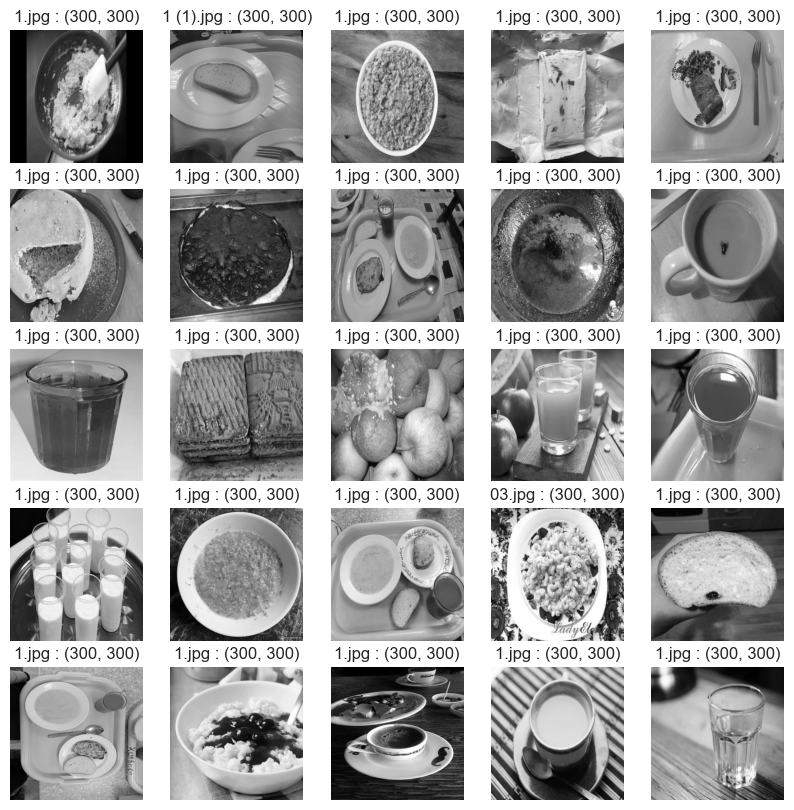

In [8]:
indices = [0, 200, 400, 600, 800, 1000]
plot([train_dataset.get_np_image(index) for index in indices]);

In [11]:
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [12]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels) !!!!!!
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )


    # Split into training (70% and testing (30%) datasets)
    # Split into training (80% and testing (20%) datasets) !
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    train_dataset, test_dataset = train_test_split(full_dataset, test_size=0.2, train_size=0.8, random_state=42)

    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=75,
        # batch_size=50,
        # batch_size=34,
        num_workers=0,
        shuffle=False
    )

    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=75,
        # batch_size=50,
        # batch_size=34,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

Data loaders ready


In [21]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# компиляция модели многолассовой классификации
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 148, 148, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 74, 74, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 72, 72, 64)      

In [22]:
early_stopping = EarlyStopping(patience=10)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, factor = 0.5, min_lr = 0.00001)
callbacks = [early_stopping, reduce_lr]

In [23]:
!nvidia-smi

Wed Dec 14 16:07:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 26%   36C    P8     6W / 100W |    104MiB /  4096MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
with tf.compat.v1.Session() as sess:
    devices = sess.list_devices()

In [25]:
with tf.device('/gpu:0'):
    history = model.fit_generator(
        train_loader,
        epochs = 10,
        validation_data = test_loader,
        callbacks = callbacks
    )

ValueError: Failed to find data adapter that can handle input: <class 'torch.utils.data.dataloader.DataLoader'>, <class 'NoneType'>